In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
csv_paths = [
    "../datasets/PlantDoc-ResNet-Random_19.csv",
    "../datasets/PlantDoc-ResNet-Random_20.csv",
    "../datasets/PlantDoc-ResNet-Random_21.csv",
    "../datasets/PlantDoc-ResNet-ImageNet_v1.csv",
    "../datasets/PlantDoc-ResNet-ImageNet_v2.csv",
    "../datasets/PlantDoc-ResNet-PDDD.csv",
    "../datasets/PlantDoc-Swin_T-Random_19.csv",
    "../datasets/PlantDoc-Swin_T-Random_20.csv",
    "../datasets/PlantDoc-Swin_T-Random_21.csv",
    "../datasets/PlantDoc-Swin_T-ImageNet.csv",
    "../datasets/PlantDoc-Swin_T-PDDD.csv",
]
csv_path = csv_paths[3]
seed = 19

In [3]:
df_comparison = pd.DataFrame()

for i, path in enumerate(csv_paths):
    df_full = pd.read_csv(csv_path, index_col=0)
    df_comparison[f"target_{i}"] = df_full["target"]
    df_comparison[f"set_{i}"] = df_full["set"]

In [4]:
df_comparison[df_comparison.columns[0::2]].T.duplicated()
# first row must be False, all other True

target_0     False
target_1      True
target_2      True
target_3      True
target_4      True
target_5      True
target_6      True
target_7      True
target_8      True
target_9      True
target_10     True
dtype: bool

In [5]:
df_comparison[df_comparison.columns[1::2]].T.duplicated()
# first row must be False, all other True

set_0     False
set_1      True
set_2      True
set_3      True
set_4      True
set_5      True
set_6      True
set_7      True
set_8      True
set_9      True
set_10     True
dtype: bool

In [6]:
df_full = pd.read_csv(csv_path, index_col=0)
df_train, df_valid = df_full[(mask := df_full["set"] == "train")], df_full[~mask]

print(f"Train size: {len(df_train)}")
df_train_targets = df_train["target"]
df_train_features = df_train.loc[:, ~df_train.columns.isin(["target", "set"])]
print(df_train_targets.value_counts()[:5])

print(f"Validation size: {len(df_valid)}")
df_valid_targets = df_valid["target"]
df_valid_features = df_valid.loc[:, ~df_valid.columns.isin(["target", "set"])]
print(df_valid_targets.value_counts()[:5])

Train size: 1873
target
8     144
18    112
15     99
13     89
11     87
Name: count, dtype: int64
Validation size: 469
target
8     36
18    28
15    25
13    23
11    22
Name: count, dtype: int64


In [7]:
scaler = StandardScaler()
train_features = scaler.fit_transform(df_train_features)
valid_features = scaler.transform(df_valid_features)

In [8]:
tsne = TSNE(n_components=2, random_state=seed)
train_features_reduced = tsne.fit_transform(X=train_features)

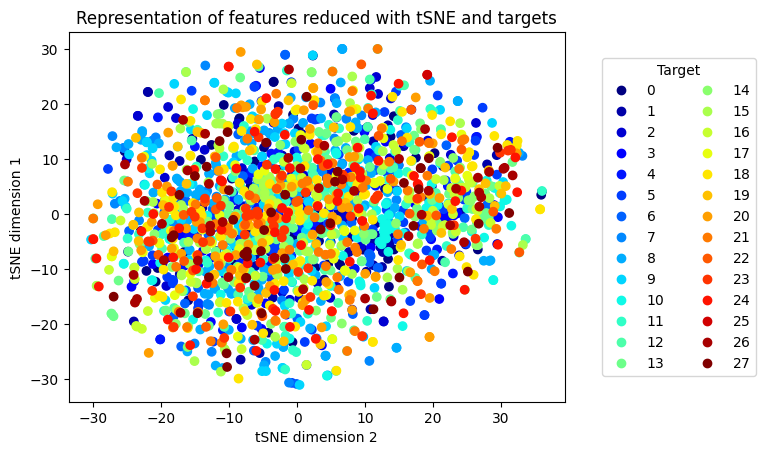

In [9]:
# plt.figure(figsize=(12, 5))
plt.title(f"Representation of features reduced with tSNE and targets")
plt.ylabel("tSNE dimension 1")
plt.xlabel("tSNE dimension 2")
scatter = plt.scatter(
    train_features_reduced[:, 0],
    train_features_reduced[:, 1],
    c=df_train_targets,
    # s=df.gdp/100,
    cmap="jet",
)
# plt.legend(range(0,16))
plt.legend(
    *scatter.legend_elements(num=df_train_targets.unique().size),
    title="Target",
    ncol=2,
    loc="right",
    bbox_to_anchor=(1.4, 0.5),
)
plt.show()

Accuracy with 1 neighbors: 0.15565031982942432
Accuracy with 2 neighbors: 0.14712153518123666
Accuracy with 3 neighbors: 0.13646055437100213
Accuracy with 4 neighbors: 0.1279317697228145
Accuracy with 5 neighbors: 0.1300639658848614
Accuracy with 6 neighbors: 0.11940298507462686
Accuracy with 7 neighbors: 0.11727078891257996
Accuracy with 8 neighbors: 0.11727078891257996
Accuracy with 9 neighbors: 0.10874200426439233
Accuracy with 10 neighbors: 0.09594882729211088
Accuracy with 11 neighbors: 0.11087420042643924
Accuracy with 12 neighbors: 0.12153518123667377
Accuracy with 13 neighbors: 0.11940298507462686
Accuracy with 14 neighbors: 0.11300639658848614
Accuracy with 15 neighbors: 0.11940298507462686


Text(0, 0.5, 'Accuracy')

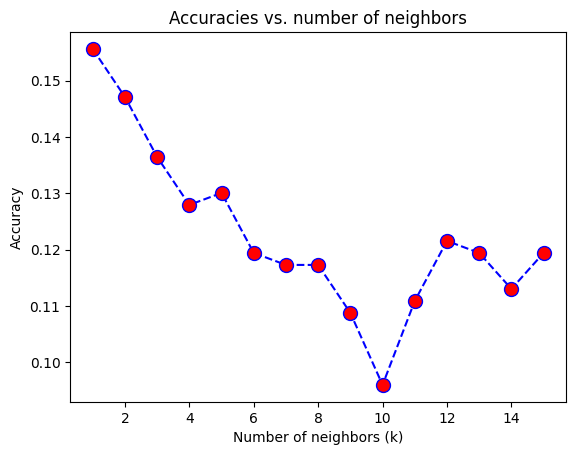

In [10]:
accuracies = []
max_neighbors = 16
for i in range(1, max_neighbors):
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(train_features, df_train_targets)
    valid_pred = model_knn.predict(valid_features)
    accuracy = accuracy_score(df_valid_targets, valid_pred)
    accuracies.append(accuracy)
    print(f"Accuracy with {i} neighbors: {accuracy}")

# plt.figure(figsize=(10,6))
plt.plot(
    range(1, max_neighbors),
    accuracies,
    color="blue",
    linestyle="dashed",
    marker="o",
    markerfacecolor="red",
    markersize=10,
)
plt.title("Accuracies vs. number of neighbors")
plt.xlabel("Number of neighbors (k)")
plt.ylabel("Accuracy")
# ResNet Random_19 (K=1): 0.07036247334754797
# ResNet Random_20 (K=1): 0.053304904051172705
# ResNet Random_21 (K=1): 0.07462686567164178
# ResNet ImageNet_v1 (K=1): 0.15565031982942432
# ResNet ImageNet_v2 (K=1): 0.10660980810234541
# ResNet PDDD (K=1): 0.18976545842217485
# Swin_T Random_19 (K=1): 0.06823027718550106
# Swin_T Random_20 (K=1): 0.0767590618336887
# Swin_T Random_21 (K=1): 0.05543710021321962
# Swin_T ImageNet (K=1): 0.39872068230277186
# Swin_T PDDD (K=1): 0.2579957356076759

In [11]:
model_lr = LogisticRegression(max_iter=10000)
model_lr.fit(train_features, df_train_targets)
valid_pred = model_lr.predict(valid_features)
accuracy = accuracy_score(df_valid_targets, valid_pred)
print(f"Accuracy: {accuracy}")
# ResNet Random_19: 0.0021321961620469083
# ResNet Random_20: 0.01279317697228145
# ResNet Random_21: 0.008528784648187633 ???
# ResNet ImageNet_v1: 0.008528784648187633 ???
# ResNet ImageNet_v2: 0.07889125799573561
# ResNet PDDD: 0.14285714285714285
# Swin_T Random_19: 0.1023454157782516
# Swin_T Random_20: 0.10660980810234541
# Swin_T Random_21: 0.12366737739872068
# Swin_T ImageNet: 0.5778251599147122
# Swin_T PDDD: 0.3411513859275053

Accuracy: 0.008528784648187633
